In [0]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.autograd.variable import Variable

from IPython import display
from matplotlib import pyplot as plt
import numpy as np

from torch.utils.data.dataset import Dataset 
from torch.utils.data import DataLoader
import pickle


In [0]:
from google.colab import drive
drive.mount('/content/drive')

train_file_pickle = "/content/drive/My Drive/Deep Learning Systems/Assignment4Part1Data/hw4_tr7.pkl"
test_file_pickle = "/content/drive/My Drive/Deep Learning Systems/Assignment4Part1Data/hw4_te7.pkl"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.encodelayer1 = nn.Linear(784, 500)
        self.encodelayer2 = nn.Linear(500, 120)
        self.encodelayer3 = nn.Linear(120, 20)
        
        self.makemean = nn.Linear(20, 4)
        self.makevariance = nn.Linear(20, 4)

        self.z_to_decoderip = nn.Linear(4, 20)
        
        self.decodelayer1 = nn.Linear(20, 120)
        self.decodelayer2 = nn.Linear(120, 500)
        self.decodelayer3 = nn.Linear(500, 784)

        self.relu = F.relu
        self.sigmoid = F.sigmoid
    
    def encode(self, x):
        x = self.relu(self.encodelayer1(x))
        x = self.relu(self.encodelayer2(x))
        x = self.relu(self.encodelayer3(x))
        return x
    
    def decode(self, z):
        z = self.z_to_decoderip(z)
        z = self.relu(self.decodelayer1(z))
        z = self.relu(self.decodelayer2(z))
        z = self.sigmoid(self.decodelayer3(z))
        return z
    
    def get_sample(self, mean, variance):
        std = variance.mul(0.5).exp_()
        esp = torch.randn(*mean.size())
        z = mean + std * esp
        return z
    
    def process_distribution(self, x):
        mean = self.makemean(x)
        variance = self.makevariance(x)
        sample = self.get_sample(mean, variance)

        return mean, variance, sample

    def forward(self, x):
        #encode the image
        x = self.encode(x)

        #process the distribution
        mean, variance, sample = self.process_distribution(x)
        
        #decode the image
        sample = self.decode(sample)

        return mean, variance, sample

def init_weights(layer):
    if isinstance(layer, nn.Linear):
        nn.init.xavier_normal_(layer.weight.data)
        nn.init.zeros_(layer.bias.data)

def vae_loss(decoded_img, encoded_img, mean, variance):
    bce = F.binary_cross_entropy(decoded_img, encoded_img, size_average=False)
    kldiv = -0.5 * torch.mean(1 + variance - mean.pow(2) - variance.exp())
    return (bce/1000) + kldiv, bce, kldiv

class VAEMNISTDataset(Dataset):
    def __init__(self, imgs):
        self.imgs = torch.from_numpy(imgs)
        
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, idx):
        return self.imgs[idx].view(-1)


net = Net()
net.apply(init_weights)
print(net)

learning_rate = 1e-3
optimizer = optim.Adam(net.parameters(), lr=learning_rate)


data = None
with open(train_file_pickle, 'rb') as f:
    data = pickle.load(f)

ds = VAEMNISTDataset(data)
trainloader = DataLoader(ds, batch_size=512, shuffle=False, num_workers=2)

Net(
  (encodelayer1): Linear(in_features=784, out_features=500, bias=True)
  (encodelayer2): Linear(in_features=500, out_features=120, bias=True)
  (encodelayer3): Linear(in_features=120, out_features=20, bias=True)
  (makemean): Linear(in_features=20, out_features=4, bias=True)
  (makevariance): Linear(in_features=20, out_features=4, bias=True)
  (z_to_decoderip): Linear(in_features=4, out_features=20, bias=True)
  (decodelayer1): Linear(in_features=20, out_features=120, bias=True)
  (decodelayer2): Linear(in_features=120, out_features=500, bias=True)
  (decodelayer3): Linear(in_features=500, out_features=784, bias=True)
)


In [0]:
epochs = 500
for epoch in range(epochs):
    for batch in trainloader:
        optimizer.zero_grad()
        mean, variance, decoded_imgs = net(batch)
        loss, bce, kld = vae_loss(decoded_imgs, batch, mean, variance)
        loss.backward()
        optimizer.step()
    if epoch%10 == 0:
        print("Epoch: {}, Loss: {}.".format(epoch, loss.data))
    klloss.append(kld)
    vaeloss.append(loss)
    encodedecodeloss.append(bce)


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch: 0, Loss: 33.62830352783203.
Epoch: 10, Loss: 18.201313018798828.
Epoch: 20, Loss: 16.599580764770508.
Epoch: 30, Loss: 16.05710792541504.
Epoch: 40, Loss: 15.685688972473145.
Epoch: 50, Loss: 15.647371292114258.
Epoch: 60, Loss: 15.29860782623291.
Epoch: 70, Loss: 15.214171409606934.
Epoch: 80, Loss: 14.950507164001465.
Epoch: 90, Loss: 14.79179573059082.
Epoch: 100, Loss: 14.817188262939453.
Epoch: 110, Loss: 14.759859085083008.
Epoch: 120, Loss: 14.533430099487305.
Epoch: 130, Loss: 14.728031158447266.
Epoch: 140, Loss: 14.587228775024414.
Epoch: 150, Loss: 14.39329719543457.
Epoch: 160, Loss: 14.390743255615234.
Epoch: 170, Loss: 14.407173156738281.
Epoch: 180, Loss: 14.346761703491211.
Epoch: 190, Loss: 14.119483947753906.
Epoch: 200, Loss: 14.638895034790039.
Epoch: 210, Loss: 14.139135360717773.
Epoch: 220, Loss: 14.029745101928711.
Epoch: 230, Loss: 14.00947380065918.
Epoch: 240, Loss: 13.984880447387695.
Epoch: 250, Loss: 13.936368942260742.
Epoch: 260, Loss: 13.92679977

In [0]:
mean_arr = []
var_arr = []
with torch.no_grad():
    for batch in trainloader:
        mean, var, sample = net(batch)
        mean_arr.append(mean)
        var_arr.append(var)
        break
mean_arr

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


[tensor([[-1.4407,  0.6390, -2.2155,  0.7653],
         [ 0.3512, -1.0235,  0.4182,  2.2800],
         [-1.1960,  0.9266, -1.4689,  0.0389],
         ...,
         [ 0.8181,  0.7206, -1.7443,  0.6115],
         [-0.5334,  1.0284, -0.6110,  0.6909],
         [-1.8767,  0.1449,  0.7711,  0.4754]])]

In [0]:
mean = mean_arr[0][0]
var = var_arr[0][0]

In [0]:
mean, var

(tensor([-1.4407,  0.6390, -2.2155,  0.7653]),
 tensor([-4.9136, -4.4309, -4.8486, -5.5370]))

In [0]:
all_dim_samples = []
for dim in range(4):
    vals = np.linspace(mean[dim]+var[dim], mean[dim]-var[dim], 10)
    for val in vals:
        s = copy.deepcopy(mean)
        s[dim] = val
        all_dim_samples.append(s)
all_dim_samples

[tensor([-6.3543,  0.6390, -2.2155,  0.7653]),
 tensor([-5.2624,  0.6390, -2.2155,  0.7653]),
 tensor([-4.1704,  0.6390, -2.2155,  0.7653]),
 tensor([-3.0785,  0.6390, -2.2155,  0.7653]),
 tensor([-1.9866,  0.6390, -2.2155,  0.7653]),
 tensor([-0.8947,  0.6390, -2.2155,  0.7653]),
 tensor([ 0.1972,  0.6390, -2.2155,  0.7653]),
 tensor([ 1.2891,  0.6390, -2.2155,  0.7653]),
 tensor([ 2.3810,  0.6390, -2.2155,  0.7653]),
 tensor([ 3.4729,  0.6390, -2.2155,  0.7653]),
 tensor([-1.4407, -3.7919, -2.2155,  0.7653]),
 tensor([-1.4407, -2.8072, -2.2155,  0.7653]),
 tensor([-1.4407, -1.8226, -2.2155,  0.7653]),
 tensor([-1.4407, -0.8380, -2.2155,  0.7653]),
 tensor([-1.4407,  0.1467, -2.2155,  0.7653]),
 tensor([-1.4407,  1.1313, -2.2155,  0.7653]),
 tensor([-1.4407,  2.1159, -2.2155,  0.7653]),
 tensor([-1.4407,  3.1006, -2.2155,  0.7653]),
 tensor([-1.4407,  4.0852, -2.2155,  0.7653]),
 tensor([-1.4407,  5.0698, -2.2155,  0.7653]),
 tensor([-1.4407,  0.6390, -7.0641,  0.7653]),
 tensor([-1.4

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


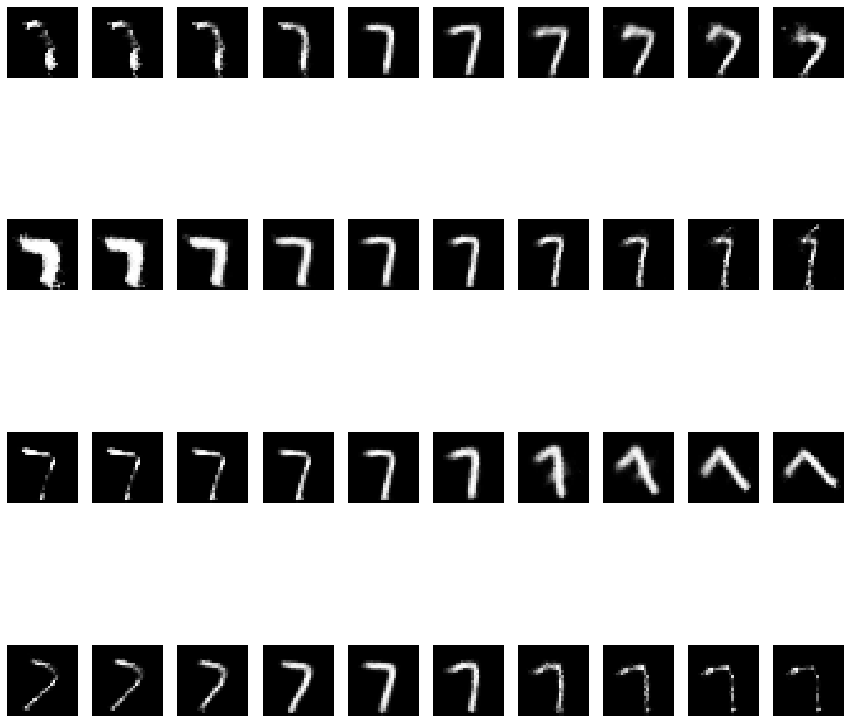

In [0]:
columns = 10
rows = 4
fig,axes = plt.subplots(nrows = rows, ncols = columns, figsize=(15,15))
for ax in axes.flatten():
    ax.axis('off')

with torch.no_grad():
    img_count = 0
    index = 0
    for val in all_dim_samples:
        x = net.decode(val)
        x = x.reshape((28,28))
        axes[index, img_count].imshow(x, cmap='gray')
        img_count+=1
        if img_count%10==0:
            img_count=0
            index+=1
fig.show()



### After Looking at the images, it looks like professor has rotated the images and the third dimension out of the 4 controls this behaviour. 
##### We can claim this as we can see in the third row, the sevens's at the end have got tilted to the left gradually as we change the values of that dimension

#### We can see thickness being controlled by second dimention

#### We can see rotation being controlled by third dimention. We can also see 4th dimention having a little bit of rotation



